# Integrating and Exploring the Combined MSI Dataset for California
## Capstone - Fall 2020
### TP Goter - September 20, 2020

This notebook is used to integrate the individual, serialized dataframes. First we explore the metadata to get some descriptive statistics about our model. Then we process that actual data into a TensorFlow data object for future use in training neural networks.

In [ ]:
import pandas as pd
import tensorflow as tf
from glob import glob
import os
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from google.colab import drive
import seaborn as sns
from matplotlib.cm import get_cmap
import folium

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(pd.__version__)
print(tf.__version__)
sns.set()

1.0.5
2.3.0


### Mount Google Drive
Authentication Required

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Set Paths to Data
Data is actually kept in a folder shared with me. In order to access it from Colab, I added a shortcut to the Shared Folder to my 'My Drive' folder on Google Drive. A link is created that allows me to create the path below to get to the actual data without having to copy it back to my personal drive.

In [ ]:
base_path = '/content/gdrive/My Drive/Capstone Project'
sentinel_path = os.path.join(base_path, 'Sentinel_CA/Level1C')

### Gather Serialzed DataFrames
Get a list of all the pkl files we need to process

In [ ]:
pkl_dfs = [pdf for pdf in os.listdir(sentinel_path) if '.pkl' == pdf[-4:]]
print(len(pkl_dfs))
pkl_dfs

60


['S2_2018_35.125_-119.875.pkl',
 'S2_2018_35.125_-119.625.pkl',
 'S2_2018_35.125_-119.375.pkl',
 'S2_2018_35.125_-119.125.pkl',
 'S2_2018_35.375_-119.875.pkl',
 'S2_2018_35.375_-119.625.pkl',
 'S2_2018_35.375_-119.375.pkl',
 'S2_2018_35.375_-119.125.pkl',
 'S2_2018_35.625_-119.875.pkl',
 'S2_2018_35.625_-119.625.pkl',
 'S2_2018_35.625_-119.375.pkl',
 'S2_2018_35.625_-119.125.pkl',
 'S2_2018_35.875_-119.875.pkl',
 'S2_2018_35.875_-119.625.pkl',
 'S2_2018_35.875_-119.375.pkl',
 'S2_2018_35.875_-119.125.pkl',
 'S2_2018_36.125_-119.875.pkl',
 'S2_2018_36.125_-119.625.pkl',
 'S2_2018_36.125_-119.375.pkl',
 'S2_2018_36.125_-119.125.pkl',
 'S2_2018_36.375_-119.875.pkl',
 'S2_2018_36.375_-119.625.pkl',
 'S2_2018_36.375_-119.375.pkl',
 'S2_2018_36.375_-119.125.pkl',
 'S2_2018_36.625_-119.875.pkl',
 'S2_2018_36.625_-119.625.pkl',
 'S2_2018_36.625_-119.375.pkl',
 'S2_2018_36.625_-119.125.pkl',
 'S2_2018_36.875_-119.875.pkl',
 'S2_2018_36.875_-119.625.pkl',
 'S2_2018_36.875_-119.375.pkl',
 'S2_201

### Read Metadata
First we will explore some metadata. We cannot read the totality of our dataframes in at once because we are RAM limited. So we will do it in steps. The data is still uploading to Google Drive, so let's just get the infrastructure in place first.

In [ ]:
# Make sure the dataframe is deleted before trying to read in each of the individual dataframes
if 'total_df' in locals():
  del total_df

# Instantiate a list to contain individual dataframes
dfs = []

# Loop over our pickle files
for pdf in tqdm(pkl_dfs):
  # Read in each pickle file but drop the MSI data and the predictions to fit within memory limitations
  dfs.append(pd.read_pickle(os.path.join(sentinel_path, pdf)).drop(['msi', 'predictions'], axis=1))

# Concatenate the dataframes togethers
total_df = pd.concat(dfs).reset_index(drop=True)

# Delete the list of dataframes to save memory
del dfs

100%|██████████| 60/60 [10:03<00:00, 10.05s/it]


In [ ]:
# High Level Statistics
total_df.describe()

,month,tot_irr_locs
count,69003.000000,69003.000000
mean,6.612626,624.229425
std,3.383546,1499.117265
min,1.000000,0.000000
25%,4.000000,0.000000
50%,7.000000,0.000000
75%,10.000000,326.000000
max,12.000000,9981.000000


### Function for Summarizing Key Statistics
- Land area of California from [Brittanica](https://www.britannica.com/place/California-state)
- Cropland area from [California Department of Food and Agriculture](https://www.cdfa.ca.gov/statistics/PDFs/2018-2019AgReportnass.pdf)
- 2013 Estimate of Irrigated Cropland in CA from [Federation of American Scientists](https://fas.org/sgp/crs/misc/R44093.pdf)




In [ ]:
def summarize_metadata(df):
  '''
  '''

  MONTHS = {1:'January',
            2:'February',
            3:'March',
            4:'April',
            5:'May',
            6:'June',
            7:'July',
            8:'August',
            9:'September',
            10:'October',
            11:'November',
            12:'December'}

  CMAP = get_cmap('tab20').colors

  CALIFORNIA_AREA = 423967 # square kms
  CALIFORNIA_CROPLAND = 6.75e7 / 640 * 2.59 # acres to sq miles to sq kms
  CALIFORNIA_IRRIGATED_AREA = 7.9e6 / 640 * 2.59 # acres to sq miles to sq kms

  # Number of images - each image exists for 11 or 12 months of 2018
  num_imgs = len(df)

  # Each image is 100 x 100 pixels
  # Each base image is 1164 x 929 pixels
  # There are 99 small images per base image
  # Thus, we use 0.9155 of the base image
  # At our latitude and longitude the 0.25 x 0.25 degree region
  # is about 616.55 km2
  # June present for all images
  unique_area = 616.55*0.9155 / 99 * len(df[df.month==6])

  # Calculate percent of land in sample that is irrigated
  irrigated_area = df.tot_irr_locs.sum() / (num_imgs * 100 * 100)
  


  
  print(10*'*' + 'SUMMARY' + 10*'*')
  print(f'Number of 100x100 10-channel "images" to process:\t{num_imgs}')
  print(f'Total Land Area in California:\t\t\t\t{CALIFORNIA_AREA} sq. km')
  print(f'Total Cropland Area in California:\t\t\t{CALIFORNIA_CROPLAND:.0f} sq. km')
  print(f'Area Covered in Images:\t\t\t\t\t{unique_area} sq. km')
  print(f'Fraction of California Area Covered in Images:\t\t{unique_area / CALIFORNIA_AREA:.3f} ')
  print(f'Fraction of Sample Irrigated:\t\t\t\t{irrigated_area:.3f} ')
  print(f'Estimated Irrigated Fraction of Land In California:\t{CALIFORNIA_IRRIGATED_AREA/CALIFORNIA_AREA:.3f}')
  print(2*'\n')
  
  # Generate Plot of Irrigated Land Fraction by Month
  avg_irr_by_month = total_df.groupby(['month']).tot_irr_locs.mean()
  fig, ax = plt.subplots(1,1, figsize=(10,5))
  ax.bar(x=[MONTHS[m] for m in avg_irr_by_month.index],
         height=avg_irr_by_month.values/10000,
         color=CMAP, edgecolor='black')
  ax.set_xticklabels([MONTHS[m] for m in avg_irr_by_month.index],
                     rotation=45, fontsize=11,fontweight='bold')
  ax.set_yticklabels([f'{n:.2f}' for n in np.arange(0.0,0.18,0.02)],
                     fontsize=11,fontweight='bold')
  ax.set_title('Mean Fraction of Land Irrigated by Month',fontsize=16,fontweight='bold')

  print(2*'\n')

  # Histogram of Irrigated Locations by Month
  irr_by_month = total_df.groupby(['month']).tot_irr_locs
  fig, axes = plt.subplots(2,6,figsize=(20,10), sharex=True, sharey=True)
  axes = axes.flatten()
  for g, group in irr_by_month:
    group = group / 10000
    group.hist(ax=axes[g-1], bins=20, color='tab:green', ec='black')
    axes[g-1].set_title(f'{MONTHS[g]}', fontweight='bold', fontsize=11)
  plt.tight_layout()
  plt.suptitle('Distribution of Irrigated Fraction by Month', y=1.02, fontsize=16, fontweight='bold')




### Top Level Summary

**********SUMMARY**********
Number of 100x100 10-channel "images" to process:	69003
Total Land Area in California:				423967 sq. km
Total Cropland Area in California:			273164 sq. km
Area Covered in Images:					33867.091499999995 sq. km
Fraction of California Area Covered in Images:		0.080 
Fraction of Sample Irrigated:				0.062 
Estimated Irrigated Fraction of Land In California:	0.075








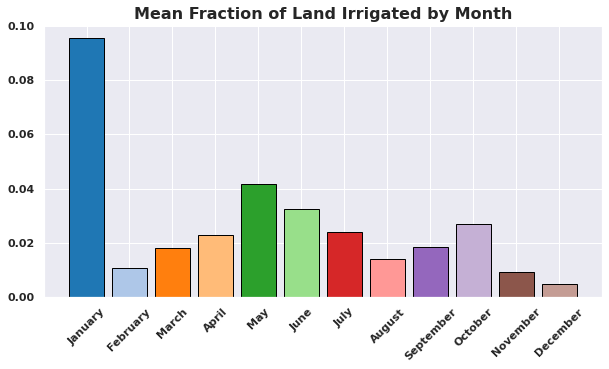

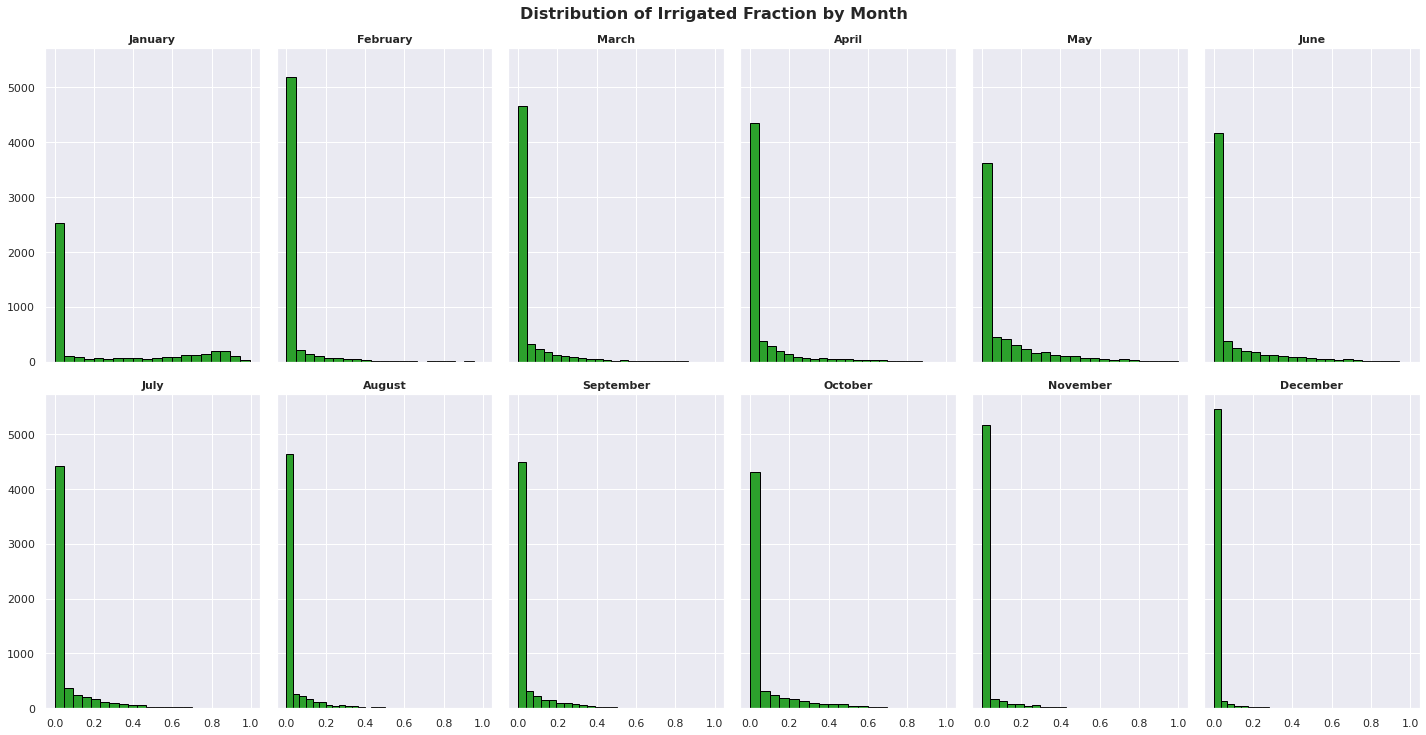

In [ ]:
summarize_metadata(total_df)

In [ ]:
# Create interactive map with default basemap
map_osm = folium.Map(
    location=[total_df.lat.median(), total_df.lon.median()],
    zoom_start=8,
    tiles='Stamen Terrain'
)

centers = total_df.groupby(['lat']).lon.unique()
month_counts = total_df.groupby(['lat']).month.unique()
for l, lat in enumerate(centers.index):
  for lon in centers[l]:

    folium.Rectangle(
    bounds=[(float(lat)-0.125, float(lon)-0.125), (float(lat)+0.125, float(lon)+0.125)],
    popup=f'{lat}, {lon}\n{len(month_counts[l])} months',
    color='#708090',
    fill=True,
    fill_color='#708090'
    ).add_to(map_osm)

map_osm